In [1]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import logging
import sys
import pickle
import joblib
import os
import gc

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization

from tensorflow.keras.regularizers import l1, l2

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# tf.config.set_visible_devices([], 'GPU')

# physical_devices = tf.config.list_physical_devices('GPU')

# tf.test.gpu_device_name()
# tf.device('/GPU:0')
# tf.device('/CPU:0')

import optuna
from optuna.samplers import TPESampler

2024-11-27 06:36:34.207010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 06:36:34.223395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732689394.240434   87183 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732689394.245295   87183 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 06:36:34.265353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("Devices available: ", tf.config.list_physical_devices())

Devices available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
num_classes = 19 #0 - 18
np.random.seed(441) #setting seed
img_rows, img_cols = 28, 28 #image dimensions

In [5]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = np.concatenate([x_train, x_test])
Y = np.concatenate([y_train, y_test])

X = X.astype('float32')
X /= 255

def dataset(X, Y):
    imgs = []
    labels = []

    for _ in range(len(X)):
        i, j = np.random.choice(len(X), size=2, replace=False)
        img1, img2 = X[i], X[j]
        combined_img = np.hstack((img1, img2))
        combined_label = Y[i] + Y[j]
        imgs.append(combined_img)
        labels.append(combined_label)
    return np.array(imgs), np.array(labels)

X, Y = dataset(X, Y)

In [6]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=(1-train_ratio), random_state=441)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=(test_ratio/(val_ratio+test_ratio)), random_state=441)

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (48999, 28, 56)
x_val shape: (14000, 28, 56)
x_test shape: (7001, 28, 56)
y_train shape: (48999,)
48999 train samples
7001 test samples
14000 validation samples


In [7]:
with open('x_train_nn.pickle', 'wb') as f:
    pickle.dump(x_train, f)

with open('y_train_nn.pickle', 'wb') as f:
    pickle.dump(y_train, f)
    
with open('x_test_nn.pickle', 'wb') as f:
    pickle.dump(x_test, f)
    
with open('y_test_nn.pickle', 'wb') as f:
    pickle.dump(y_test, f)

with open('x_val_nn.pickle', 'wb') as f:
    pickle.dump(x_val, f)
    
with open('y_val_nn.pickle', 'wb') as f:
    pickle.dump(y_val, f)

In [4]:
with open('x_train_nn.pickle', 'rb') as f:
    x_train = pickle.load(f)

with open('y_train_nn.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with open('x_test_nn.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with open('y_test_nn.pickle', 'rb') as f:
    y_test = pickle.load(f)

with open('x_val_nn.pickle', 'rb') as f:
    x_val = pickle.load(f)
    
with open('y_val_nn.pickle', 'rb') as f:
    y_val = pickle.load(f)

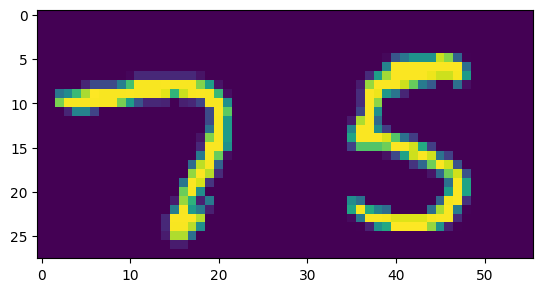

12


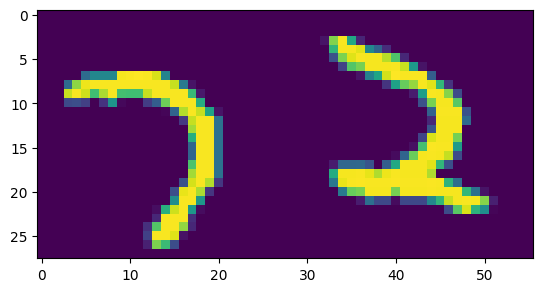

9


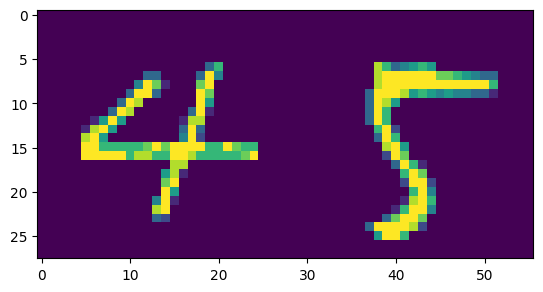

9


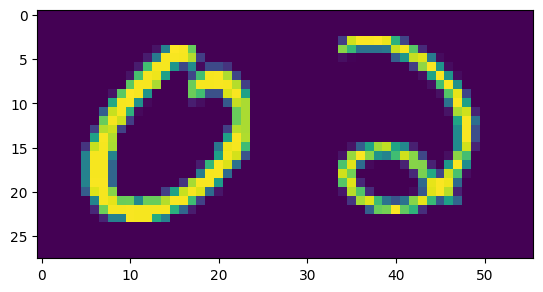

2


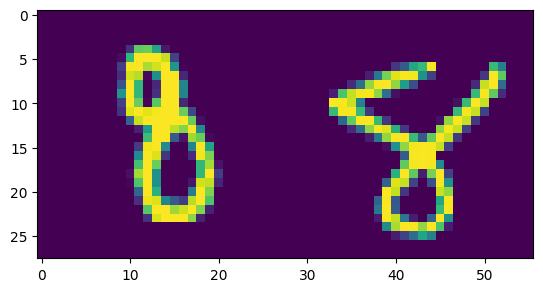

16


In [5]:
for i in range(5):
    plt.imshow(x_train[i])
    plt.show()
    print(np.where(y_train[i]==1)[0][0])

In [7]:
s_name = "nn_study6"
m_name = "nn_model6"

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-4, log=True)
    n_neurons = trial.suggest_int('n_neurons', 64, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    l1_regularization = trial.suggest_float('l1_regularization', 1e-5, 1e-4)
    n_layers = trial.suggest_int('n_layers', 2, 3)
    
    model = Sequential()
    model.add(Input(shape=(56, 28)))
    model.add(Flatten())

    for _ in range(n_layers):
        model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l1(l1_regularization)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    model_checkpoint = ModelCheckpoint(f"best_{m_name}.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=0)
    with tf.device('/GPU:0'):
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=11,
                        batch_size=8, verbose=0, callbacks=[model_checkpoint, early_stopping, reduce_lr])
    
        score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]

    backend.clear_session()
    del model
    gc.collect()

    return accuracy

study = optuna.create_study(direction='maximize', study_name=s_name, storage=f"sqlite:///{s_name}.db", load_if_exists=True, sampler=TPESampler(seed=441))

study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-11-27 06:37:27,213] A new study created in RDB with name: nn_study6


  0%|          | 0/50 [00:00<?, ?it/s]

I0000 00:00:1732689447.786317   87183 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1732689453.227291   87827 service.cc:148] XLA service 0x7f85700056d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732689453.229173   87827 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-11-27 06:37:33.280803: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732689453.533533   87827 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-27 06:37:35.310539: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gem

In [5]:
print('Best trial:')
print(f' Value: {study.best_trial.value}')
print(' Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial:
 Value: 0.913100004196167
 Params: 
    learning_rate: 9.999014745181874e-05
    n_neurons: 566
    dropout_rate: 0.0002658695997620067
    l1_regularization: 4.540153304979403e-05
    n_layers: 6


In [6]:
def create_and_save_model(study):
    with open("sampler.pkl", "wb") as fout:
        pickle.dump(study.sampler, fout)
        
    params = study.best_trial.params
    model = Sequential()
    model.add(Flatten(input_shape=(56, 28)))
    print()
    for _ in range(params.get('n_layers')):
        model.add(Dense(params.get('n_neurons'), activation='relu', kernel_regularizer=l1(params.get('l1_regularization'))))
        model.add(Dropout(params.get('dropout_rate')))

    model.add( Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(params.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50,
                        batch_size=128, verbose=1)

    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]
    print(accuracy)
    model.save(f'{m_name}.keras')
    with open('nn_history.pkl', "wb") as file:
        pickle.dump(history.history, file)

create_and_save_model(study)


Epoch 1/50
449/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1892 - loss: 5.6829

2024-11-23 16:44:00.514681: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2772', 36 bytes spill stores, 36 bytes spill loads

2024-11-23 16:44:00.682487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2772', 36 bytes spill stores, 36 bytes spill loads



469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1952 - loss: 5.6519

2024-11-23 16:44:04.891499: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 28 bytes spill stores, 28 bytes spill loads

2024-11-23 16:44:04.952995: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 312 bytes spill stores, 324 bytes spill loads

2024-11-23 16:44:05.378935: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 12 bytes spill stores, 12 bytes spill loads

2024-11-23 16:44:05.400460: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 840 bytes spill stores, 840 bytes spill loads

2024-11-23 16:44:05.512738: I external/local_xla/xla/stream_

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.1955 - loss: 5.6502 - val_accuracy: 0.6033 - val_loss: 3.6782
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6658 - loss: 3.4312 - val_accuracy: 0.7566 - val_loss: 3.0190
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7897 - loss: 2.8981 - val_accuracy: 0.8126 - val_loss: 2.7605
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8437 - loss: 2.6518 - val_accuracy: 0.8322 - val_loss: 2.6165
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8732 - loss: 2.4776 - val_accuracy: 0.8523 - val_loss: 2.4871
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8966 - loss: 2.3360 - val_accuracy: 0.8558 - val_loss: 2.4049
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9116 - loss: 2.2210 - val_accuracy: 0.8674 - val_loss: 2.3151
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9267 - loss: 2.1133 - val_accuracy: 0.8619 - va

2024-11-23 16:45:24.137556: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 28 bytes spill stores, 28 bytes spill loads

2024-11-23 16:45:24.370420: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 288 bytes spill stores, 292 bytes spill loads

2024-11-23 16:45:24.679808: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 668 bytes spill stores, 680 bytes spill loads

2024-11-23 16:45:24.878755: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 216 bytes spill stores, 216 bytes spill loads

2024-11-23 16:45:24.942944: I external/local_xla/xla/stream_ex

0.9002000093460083


In [7]:
model = load_model(f'{m_name}.keras')
sampler = pickle.load(open("sampler.pkl", "rb"))
history = pickle.load(open("nn_history.pkl", "rb"))

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 566)            │       888,054 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 566)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 566)            │       320,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 566)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 566)            │       320,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 566)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 566)            │       320,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 566)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 566)            │       320,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 566)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 566)            │       320,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 566)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 19)             │        10,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,510,313 (28.65 MB)

 Trainable params: 2,503,437 (9.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,006,876 (19.10 MB)

In [9]:
mask = (model.predict(np.array(x_test).reshape((10000, 28*56))) != y_test)
x_false = x_test[mask]

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 1568), dtype=float32). Expected shape (None, 56, 28), but input has incompatible shape (32, 1568)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 1568), dtype=float32)
  • training=False
  • mask=None

In [ ]:
print(x_test.shape)  # Should be (n_samples, n_features)
print(y_test.shape)  # Should be (n_samples,) for classification or (n_samples, n_labels) for multi-label tasks
predictions = model.predict(x_test)
print(predictions.shape)  # Check the shape of the predicted outputs


In [ ]:
print(model.predict(np.array(x_test))[:5])
print(y_test[:5])